In [1]:
from IPython.core.display import HTML

#with open('creative_commons.txt', 'r') as f:
#    html = f.read()
    
name = '2014-03-10-google-earth'

#html = """
#<small>
#<p> This post was written as an IPython notebook.  It is available for
#<a href="https://ocefpaf.github.com/python4oceanographers/downloads/
#notebooks/%s.ipynb">download</a> or as a static
#<a href="https://nbviewer.ipython.org/url/ocefpaf.github.com/
##python4oceanographers/downloads/notebooks/%s.ipynb">html</a>.</p>
#<p></p>
#%s """ % (name, name, html)

%matplotlib inline
from matplotlib import style
style.use('ggplot')

Here is a quick example on how to create a `kmzfile` with image overlays using
[matplotlib](http://matplotlib.org/) and
[simplekml](https://code.google.com/p/simplekml/).

The `make_kml()` function below is just a wrapper around `simplekml`.  It takes as
arguments:
- A list of matplotlib figures;
- The figure(s) LatLon box (all overlays must have the **same bbox**);
- An optional keyword for the colorbar for one of the overlays;
- Some keyword options to tweak the kml/kmz file.

All keywords (`kw`) can be modified during the `make_kml()` call.  You can read
more about them [here](http://simplekml.readthedocs.org/en/latest/).

In [2]:
from simplekml import (Kml, OverlayXY, ScreenXY, Units, RotationXY,
                       AltitudeMode, Camera)


def make_kml(llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat,
             figs, colorbar=None, **kw):
    """TODO: LatLon bbox, list of figs, optional colorbar figure,
    and several simplekml kw..."""

    kml = Kml()
    altitude = kw.pop('altitude', 2e7)
    roll = kw.pop('roll', 0)
    tilt = kw.pop('tilt', 0)
    altitudemode = kw.pop('altitudemode', AltitudeMode.relativetoground)
    camera = Camera(latitude=np.mean([urcrnrlat, llcrnrlat]),
                    longitude=np.mean([urcrnrlon, llcrnrlon]),
                    altitude=altitude, roll=roll, tilt=tilt,
                    altitudemode=altitudemode)

    kml.document.camera = camera
    draworder = 0
    for fig in figs:  # NOTE: Overlays are limited to the same bbox.
        draworder += 1
        ground = kml.newgroundoverlay(name='GroundOverlay')
        ground.draworder = draworder
        ground.visibility = kw.pop('visibility', 1)
        ground.name = kw.pop('name', 'overlay')
        ground.color = kw.pop('color', '9effffff')
        ground.atomauthor = kw.pop('author', 'ocefpaf')
        ground.latlonbox.rotation = kw.pop('rotation', 0)
        ground.description = kw.pop('description', 'Matplotlib figure')
        ground.gxaltitudemode = kw.pop('gxaltitudemode',
                                       'clampToSeaFloor')
        ground.icon.href = fig
        ground.latlonbox.east = llcrnrlon
        ground.latlonbox.south = llcrnrlat
        ground.latlonbox.north = urcrnrlat
        ground.latlonbox.west = urcrnrlon

    if colorbar:  # Options for colorbar are hard-coded (to avoid a big mess).
        screen = kml.newscreenoverlay(name='ScreenOverlay')
        screen.icon.href = colorbar
        screen.overlayxy = OverlayXY(x=0, y=0,
                                     xunits=Units.fraction,
                                     yunits=Units.fraction)
        screen.screenxy = ScreenXY(x=0.015, y=0.075,
                                   xunits=Units.fraction,
                                   yunits=Units.fraction)
        screen.rotationXY = RotationXY(x=0.5, y=0.5,
                                       xunits=Units.fraction,
                                       yunits=Units.fraction)
        screen.size.x = 0
        screen.size.y = 0
        screen.size.xunits = Units.fraction
        screen.size.yunits = Units.fraction
        screen.visibility = 1

    kmzfile = kw.pop('kmzfile', 'overlay.kmz')
    kml.savekmz(kmzfile)

We will also need a `gearth_fig()` function.  It is actually is a wrapper
around matplotlib's `Figure` and `Axes` to create a figure that is
"Google-Earth KML" friendly.  The ideas for this function are originally from
the [octant](https://github.com/hetland/octant/blob/master/octant/sandbox/googleearth.py) library.

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def gearth_fig(llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat, pixels=1024):
    """Return a Matplotlib `fig` and `ax` handles for a Google-Earth Image."""
    aspect = np.cos(np.mean([llcrnrlat, urcrnrlat]) * np.pi/180.0)
    xsize = np.ptp([urcrnrlon, llcrnrlon]) * aspect
    ysize = np.ptp([urcrnrlat, llcrnrlat])
    aspect = ysize / xsize

    if aspect > 1.0:
        figsize = (10.0 / aspect, 10.0)
    else:
        figsize = (10.0, 10.0 * aspect)

    if False:
        plt.ioff()  # Make `True` to prevent the KML components from poping-up.
    fig = plt.figure(figsize=figsize,
                     frameon=False,
                     dpi=pixels//10)
    # KML friendly image.  If using basemap try: `fix_aspect=False`.
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(llcrnrlon, urcrnrlon)
    ax.set_ylim(llcrnrlat, urcrnrlat)
    return fig, ax

In [12]:
We will test it with the Mean Dynamic Topography from
[AVISO](http://www.aviso.altimetry.fr/en/).  Below are examples for two
overlays, the Mean Dynamic Topography and the velocity vectors derived from it.

SyntaxError: invalid syntax (<ipython-input-12-6cce8f21f12e>, line 1)

In [13]:
import numpy.ma as ma
from netCDF4 import Dataset, date2index, num2date

nc = Dataset('F:/data/sst/jpl_mur/v4.1/2017/007/20170107090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')

sst = nc.variables['analysed_sst'][:,11500:13000,5500:7000]
#u = nc.variables['Grid_0002'][:]
#v = nc.variables['Grid_0003'][:]

lat = nc.variables['lat'][11500:13000]
lon = nc.variables['lon'][5500:7000]
nc.close()
lat, lon = np.meshgrid(lat, lon)

#mdt = nc.variables['Grid_0001'][:]
sst = ma.masked_equal(sst, 9999.0)


In [14]:
#here i squeeze array and flip coordinates
print(sst.shape,lon.shape,lat.shape,type(sst))
sst2 = sst[0,:,:]
print(sst2.shape)
sst3 = ma.swapaxes(sst2,0,1)
print(sst3.shape)

(1, 1500, 1500) (1500, 1500) (1500, 1500) <class 'numpy.ma.core.MaskedArray'>
(1500, 1500)
(1500, 1500)


Overlay 1:

In [15]:
from palettable import colorbrewer

pixels = 1024 * 10
cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap

fig, ax = gearth_fig(llcrnrlon=lon.min(),
                     llcrnrlat=lat.min(),
                     urcrnrlon=lon.max(),
                     urcrnrlat=lat.max(),
                     pixels=pixels)
cs = ax.pcolormesh(lon, lat, sst3 - 273.15, cmap=cmap, vmin = 11, vmax = 20)
ax.set_axis_off()
fig.savefig('overlay1.png', transparent=False, format='png')
print('done')

done


the colorbar for overlay 1,

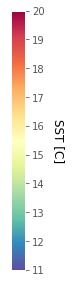

In [16]:
fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('SST [C]', rotation=-90, color='k', labelpad=20)
fig.savefig('legend.png', transparent=False, format='png')  # Change transparent to True if your colorbar is not on space :)

... and overlay 2

In [17]:
make_kml(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
         urcrnrlon=lon.max(), urcrnrlat=lat.max(),
         figs=['overlay1.png'], colorbar='legend.png',
         kmzfile='sst_mur.kmz', name='Sea Surface Temperature')

In [18]:
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
def listFD(url, ext=''):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + node.get('href') for node in soup.find_all('a') if (node.get('href').endswith(ext) and node.get('href').startswith('2'))]


reading: F:/data/cruise_data/saildrone/baja-2018/viirs_files.npy
reading: F:/data/cruise_data/saildrone/baja-2018/viirs_sst_data.npy
121 34233 https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3U/VIIRS_NPP/OSPO/v2.41/2018/140/20180520201000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.41-v02.0-fv01.0.nc
131 51489 https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3U/VIIRS_NPP/OSPO/v2.41/2018/140/20180520215000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.41-v02.0-fv01.0.nc
51 27813 https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3U/VIIRS_NPP/OSPO/v2.41/2018/141/20180521083000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.41-v02.0-fv01.0.nc
61 56499 https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3U/VIIRS_NPP/OSPO/v2.41/2018/141/20180521101000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.41-v02.0-fv01.0.nc
119 31166 https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3U/VIIR

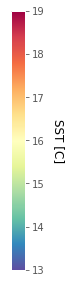

In [19]:
from os.path import exists

filename_viirs_proc = 'F:/data/cruise_data/saildrone/baja-2018/viirs_files.npy'
filename_viirs_sst = 'F:/data/cruise_data/saildrone/baja-2018/viirs_sst_data.npy'
filename_png = 'F:/data/cruise_data/saildrone/baja-2018/recent_viirs_sst.png'
filename_kmz = 'F:/data/cruise_data/saildrone/baja-2018/recent_viirs_sst.kmz'

if exists(filename_viirs_proc):
    print('reading:',filename_viirs_proc)
    proc_save = np.load(filename_viirs_proc)
else:
    proc_save = np.zeros((367,24,60))
  

inew_data=0 #initialize for new data
if exists(filename_viirs_sst):
    print('reading:',filename_viirs_sst)
    sst_new = np.load(filename_viirs_sst)
else:
    inew_data=1  
    
itotal_proc = 0

for incr_day in range(-9,1):
    d = datetime.today() + timedelta(days=incr_day)
    day_of_year = d.timetuple().tm_yday

    url = 'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3U/VIIRS_NPP/OSPO/v2.41/' \
            + str(d.year) + '/' + str(day_of_year).zfill(3) + '/'
    ext = 'nc'

    filenames=listFD(url, ext)
    ilen=len(filenames)
    for ic in range(1,ilen):
        file = filenames[ic]
        
        #save which files have been processed
        idyj=int(file[101:104])
        ihr=int(file[113:115])
        imin=int(file[115:117])
        if proc_save[idyj,ihr,imin]==1:
            continue #if file already processed skip
            
        proc_save[idyj,ihr,imin]=1
        itotal_proc = itotal_proc+1

        nc = Dataset(file)
        sst = nc.variables['sea_surface_temperature'][:,2500:3250,2500:3500]
        sst = np.flip(sst, 2)
        cnt = ma.count(sst)
        lat = nc.variables['lat'][2500:3250]
        lat = np.flip(lat, 0)
        lon = nc.variables['lon'][2500:3500]
        nc.close()
        if inew_data==1:
            sst_new = ma.copy(sst)
            inew_data = 0
        if cnt<5:
            continue
        print(ic,cnt,file)
        mask = sst_new < -10
        sst_new[mask] = sst[mask]
        
if itotal_proc>0:
    lat, lon = np.meshgrid(lat, lon)

    mask = (sst_new < -10)
    sst_new[mask]=-9999.
    sst_new2 = sst_new[0,:,:]
    sstx = ma.masked_values (sst_new2, -9999.)
    print(lon.shape,lat.shape,sstx.shape)
    sst3x = np.flip(sstx, 1)
    sst4x = np.flip(sst3x, 0)
    sst5x = ma.swapaxes(sst4x,0,1)
    print(lon.shape,lat.shape,sst5x.shape)

    pixels = 1024 * 10
    cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap

    fig, ax = gearth_fig(llcrnrlon=lon.min(),
                                     llcrnrlat=lat.min(),
                                     urcrnrlon=lon.max(),
                                     urcrnrlat=lat.max(),
                                     pixels=pixels)
    cs = ax.pcolormesh(lon, lat, sst5x - 273.15, cmap=cmap, vmin = 13, vmax = 19)
    ax.set_axis_off()
    fig.savefig(filename_png, transparent=False, format='png')
    print('done')        
    print(lat[1,1],lat[1,-1],lon[1,1],lon[-1,1])
    make_kml(llcrnrlon=lon[1,1], llcrnrlat=lat[1,1],
             urcrnrlon=lon[-1,1], urcrnrlat=lat[1,-1],
             figs= [filename_png], colorbar='legend.png',
             kmzfile=filename_kmz, name='VIIRS Sea Surface Temperature')
    np.save(filename_viirs_proc, proc_save)
    sst_new.dump(filename_viirs_sst)

fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('SST [C]', rotation=-90, color='k', labelpad=20)
fig.savefig('legend.png', transparent=False, format='png')  # Change transparent to True if your colorbar is not on space :)


done
25.03 39.99 -129.97 -110.01


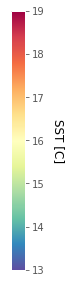

In [20]:
pixels = 1024 * 10
cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap

fig, ax = gearth_fig(llcrnrlon=lon.min(),
                                     llcrnrlat=lat.min(),
                                     urcrnrlon=lon.max(),
                                     urcrnrlat=lat.max(),
                                     pixels=pixels)
cs = ax.pcolormesh(lon, lat, sst5x - 273.15, cmap=cmap, vmin = 13, vmax = 19)
ax.set_axis_off()
fig.savefig(filename_png, transparent=False, format='png')
print('done')        
print(lat[1,1],lat[1,-1],lon[1,1],lon[-1,1])
make_kml(llcrnrlon=lon[1,1], llcrnrlat=lat[1,1],
             urcrnrlon=lon[-1,1], urcrnrlat=lat[1,-1],
             figs= [filename_png], colorbar='legend.png',
             kmzfile=filename_kmz, name='VIIRS Sea Surface Temperature')
np.save(filename_viirs_proc, proc_save)
sst_new.dump(filename_viirs_sst)

fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('SST [C]', rotation=-90, color='k', labelpad=20)
fig.savefig('legend.png', transparent=False, format='png')  # Change transparent to True if your colorbar is not on space :)


In [264]:
fig, ax = gearth_fig(llcrnrlon=lon.min(),
                                     llcrnrlat=lat.min(),
                                     urcrnrlon=lon.max(),
                                     urcrnrlat=lat.max(),
                                     pixels=pixels)
cs = ax.pcolormesh(lon, lat, sst5x - 273.15, cmap=cmap, vmin = 11, vmax = 20)
ax.set_axis_off()
fig.savefig(filename_png, transparent=False, format='png')
print('done')        
print(lat[1,1],lat[1,-1],lon[1,1],lon[-1,1])
make_kml(llcrnrlon=lon[1,1], llcrnrlat=lat[1,1],
         urcrnrlon=lon[-1,1], urcrnrlat=lat[1,-1],
         figs= [filename_png], colorbar='legend.png',
         kmzfile=filename_kmz, name='VIIRS Sea Surface Temperature')



done
25.03 39.99 -129.97 -110.01


In [252]:
proc_save = np.zeros((367,24,60))
for incr_day in range(-3,1):
    d = datetime.today() + timedelta(days=incr_day)
    day_of_year = d.timetuple().tm_yday

    url = 'https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3U/VIIRS_NPP/OSPO/v2.41/' \
            + str(d.year) + '/' + str(day_of_year).zfill(3) + '/'
    ext = 'nc'
    filenames=listFD(url, ext)
    ilen=len(filenames)
    for ic in range(1,ilen):
        file = filenames[ic]
        idyj=int(file[101:104])
        ihr=int(file[113:115])
        imin=int(file[115:117])
        proc_save[idyj,ihr,imin]=0
        #print(idyj,ihr,imin)

np.save('F:/data/cruise_data/saildrone/baja-2018/viirs_files.npy', proc_save)
#https://opendap.jpl.nasa.gov/opendap/OceanTemperature/ghrsst/data/GDS2/L3U/VIIRS_NPP/OSPO/v2.41/2018/135/20180515001000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.41-v02.0-fv01.0.nc
#        break
#    break
#numpy.readtxt('F:/data/cruise_data/saildrone/baja-2018/viirs_files.txt')



25.03 39.99 -129.97 -110.01


In [210]:
nc = Dataset(file)
lon = nc.variables['lon'][2500:3500]
lat = nc.variables['lat'][2500:3250]
lat = np.flip(lat, 0)
nc.close()
print(lon[1],lon[-1],lat[1],lat[-1])

-129.97 -110.01 25.03 39.99


In [211]:
type(sstx)


numpy.ma.core.MaskedArray

With the saved fiures we are ready to call `make_kml`.

IndexError: too many indices for array

All done!  You can inspect the KMZ [file](mdt_uv.kmz) yourself.